In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime as dt

In [2]:
# matplotlib에게 notebook에서 그림을 그리도록 지시
%matplotlib inline
# Jupyter Notebook 상에서 한글이 깨지지 않고 나오도록 조치
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# config 설정으로 고화질 도표 생성
%config InlineBackend.figure_format = 'svg'

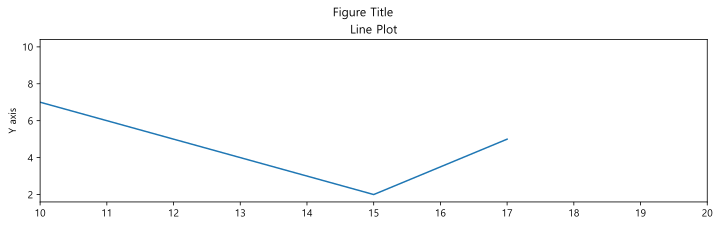

In [9]:
x = [-3, 5, 7]
y = [10, 2, 5]
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylabel('Y axis')
ax.set_title('Line Plot')
fig.suptitle('Figure Title', y=1.03)
ax.set_xticks(range(0, 11), labels=range(10, 21))
plt.show()

In [11]:
p1 = Path.cwd() / 'back_data'
alta = pd.read_csv(p1 / 'alta-noaa-1980-2019.csv', parse_dates=['DATE'], index_col='DATE')
alta.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DAPR,DASF,MDPR,MDSF,PRCP,...,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.10,...,29.0,38.0,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.43,...,34.0,27.0,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.09,...,30.0,27.0,12.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.00,...,30.0,31.0,18.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.00,...,30.0,34.0,26.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data = (alta
        .sort_index()
        .loc['2018-09':'2019-08', 'SNWD']
        .interpolate()
)
data.head()

DATE
2018-09-01    0.0
2018-09-02    0.0
2018-09-03    0.0
2018-09-04    0.0
2018-09-05    0.0
Name: SNWD, dtype: float64

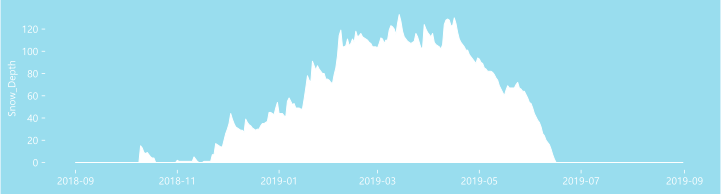

In [23]:
blue = '#99ddee'
white = '#ffffff'
fig, ax = plt.subplots(figsize=(12, 3), linewidth=5, facecolor=blue)
ax.set_facecolor(blue)
for line in ['top', 'bottom', 'left', 'right']:
    ax.spines[line].set_visible(False)
# tick color와 label color를 모두 바꿔주기에 color's'
ax.tick_params(axis='both', colors=white)
ax.set_ylabel('Snow_Depth', color=white)
ax.fill_between(data.index, data, color=white)

In [36]:
(alta
        .sort_index()
        .loc['2018-09':'2019-08', 'SNWD']
        .to_frame()
        .assign(next=lambda df: df.SNWD.shift(-1),
                snow_diff=lambda df: df.next.sub(df.SNWD))
        #.loc[:, 'snow_diff'].values
        .query("snow_diff > 20 or snow_diff < -20")
        #.interpolate()
)

,SNWD,next,snow_diff
DATE,,,
2019-03-28,103.0,124.0,21.0


In [39]:
(alta
        .sort_index()
        .loc[:, 'SNWD']
        .to_frame()
        .assign(next=lambda df: df.SNWD.shift(-1),
                snow_diff=lambda df: df.next.sub(df.SNWD))
        #.loc[:, 'snow_diff'].values
        .query("snow_diff > 50 or snow_diff < -50")
        #.interpolate()
)

,SNWD,next,snow_diff
DATE,,,
1989-11-27,60.0,0.0,-60.0
2007-02-28,87.0,9.0,-78.0
2008-05-22,62.0,0.0,-62.0
2008-05-23,0.0,66.0,66.0
2009-01-16,76.0,0.0,-76.0
2009-01-17,0.0,70.0,70.0
2009-05-14,52.0,0.0,-52.0
2009-05-15,0.0,51.0,51.0
2009-05-17,55.0,0.0,-55.0


In [40]:
def fix_gaps(ser, thrs=50):
    mask = (ser
            .to_frame()
            .assign(next=lambda df: df.SNWD.shift(-1),
                    snow_diff=lambda df: df.next.sub(df.SNWD))
        .pipe(lambda df: df.snow_diff.abs() > thrs)
    )
    return ser.where(~mask, np.nan)

<AxesSubplot:xlabel='DATE'>

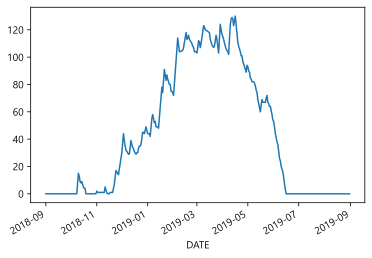

In [46]:
(alta
        .sort_index()
        .loc['2018-09':'2019-08', 'SNWD']
        .pipe(fix_gaps, thrs=5)
        #.loc[:, 'snow_diff'].values
        .interpolate()
        .plot()
)

In [47]:
flights = pd.read_csv(p1 / 'flights.csv')
flights.head()

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
0,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
1,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
3,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
4,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


In [54]:
cols = ['DIVERTED', 'CANCELLED', 'DELAYED']
(flights
 .assign(DELAYED=flights.loc[:, 'ARR_DELAY'].ge(15).astype('int'),
         ON_TIME=lambda df: 1 - df.loc[:, cols].any(axis=1))
#.select_dtypes('int')
.loc[:, ['DIVERTED', 'CANCELLED', 'DELAYED', 'ON_TIME']]
)

,DIVERTED,CANCELLED,DELAYED,ON_TIME
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0
...,...,...,...,...
58487,0,0,0,1
58488,0,0,0,1
58489,0,0,0,1
58490,0,0,1,0


In [57]:
df_date = (flights.loc[:, ['MONTH', 'DAY']]
           .assign(YEAR=2015, HOUR=flights.loc[:, 'SCHED_DEP'] // 100, MINUTE=flights.loc[:, 'SCHED_DEP'] % 100)
)
flights.index = pd.to_datetime(df_date)
flights.head()

,MONTH,DAY,WEEKDAY,AIRLINE,ORG_AIR,DEST_AIR,SCHED_DEP,DEP_DELAY,AIR_TIME,DIST,SCHED_ARR,ARR_DELAY,DIVERTED,CANCELLED
2015-01-01 16:25:00,1,1,4,WN,LAX,SLC,1625,58.0,94.0,590,1905,65.0,0,0
2015-01-01 08:23:00,1,1,4,UA,DEN,IAD,823,7.0,154.0,1452,1333,-13.0,0,0
2015-01-01 13:05:00,1,1,4,MQ,DFW,VPS,1305,36.0,85.0,641,1453,35.0,0,0
2015-01-01 15:55:00,1,1,4,AA,DFW,DCA,1555,7.0,126.0,1192,1935,-7.0,0,0
2015-01-01 17:20:00,1,1,4,WN,LAX,MCI,1720,48.0,166.0,1363,2225,39.0,0,0


<AxesSubplot:>

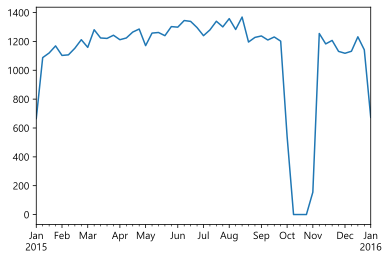

In [60]:
(flights
    .groupby(pd.Grouper(freq='W'))
    .size()
    .interpolate()
    .plot.line()
)

In [61]:
def interp(df, n=600):
    return df.where(df > n, np.nan).interpolate(limit_direction='both')

<AxesSubplot:>

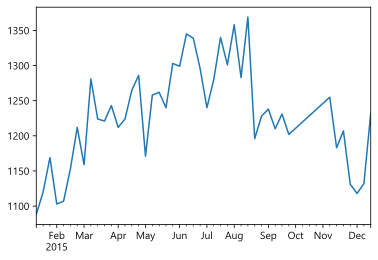

In [64]:
(flights
    .groupby(pd.Grouper(freq='W'))
    .size()
    .pipe(interp)
    .iloc[1:-2]
    .plot.line()
)

In [67]:
data = (flights
    .groupby(pd.Grouper(freq='W'))
    .size()
    .iloc[1:-2]
)
data

2015-01-11    1088
2015-01-18    1120
2015-01-25    1169
2015-02-01    1103
2015-02-08    1107
2015-02-15    1153
2015-02-22    1212
2015-03-01    1159
2015-03-08    1281
2015-03-15    1224
2015-03-22    1221
2015-03-29    1243
2015-04-05    1212
2015-04-12    1224
2015-04-19    1265
2015-04-26    1286
2015-05-03    1171
2015-05-10    1258
2015-05-17    1262
2015-05-24    1240
2015-05-31    1303
2015-06-07    1299
2015-06-14    1345
2015-06-21    1339
2015-06-28    1296
2015-07-05    1240
2015-07-12    1280
2015-07-19    1340
2015-07-26    1301
2015-08-02    1358
2015-08-09    1283
2015-08-16    1369
2015-08-23    1196
2015-08-30    1228
2015-09-06    1238
2015-09-13    1210
2015-09-20    1231
2015-09-27    1202
2015-10-04     541
2015-10-11       0
2015-10-18       0
2015-10-25       0
2015-11-01     155
2015-11-08    1255
2015-11-15    1183
2015-11-22    1207
2015-11-29    1131
2015-12-06    1118
2015-12-13    1132
2015-12-20    1232
Freq: W-SUN, dtype: int64

Text(0.8, 0.7, 'missing data')

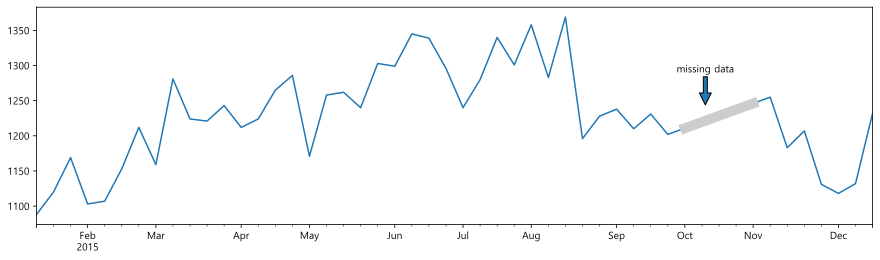

In [77]:
fig, ax = plt.subplots(figsize=(15, 4))
(data
 .pipe(interp)
 .plot.line(ax=ax)
)
mask = data < 600
(data
 .pipe(interp)
 .loc[mask]
 .plot.line(ax=ax, color='0.8', linewidth=10)
)
ax.annotate(text='missing data', xy=(0.8, 0.55), xytext=(0.8, 0.7), xycoords='axes fraction', ha='center', arrowprops=dict())

<AxesSubplot:xlabel='DEST_AIR'>

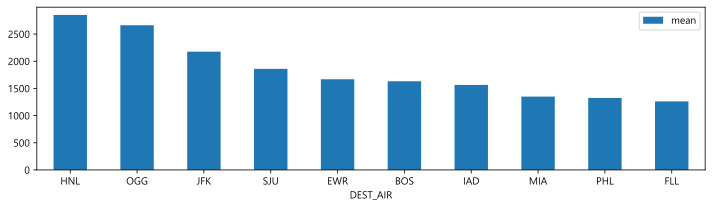

In [82]:
fig, ax = plt.subplots(figsize=(12, 3))
(flights
 .groupby(['DEST_AIR'])['DIST']
 .agg(['mean', 'count'])
 .query("count > 100")
 .sort_values('mean', ascending=False)
 .head(10)
 .plot.bar(y='mean', rot=0, ax=ax)
)

<AxesSubplot:xlabel='DIST', ylabel='AIR_TIME'>

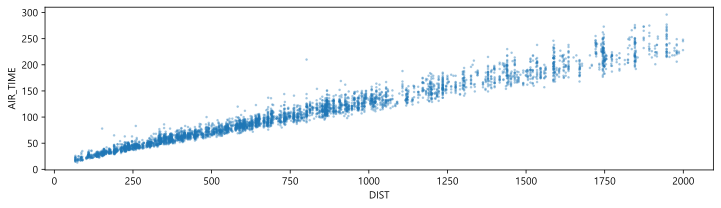

In [93]:
fig, ax = plt.subplots(figsize=(12, 3))
(flights
 .loc[:, ['DIST', 'AIR_TIME']]
 .query("DIST < 2000")
 .sample(5000, random_state=42)
 .dropna()
 .plot.scatter(x='DIST', y='AIR_TIME', ax=ax, alpha=0.3, s=3)
)

In [96]:
(flights
 .loc[:, ['DIST', 'AIR_TIME']]
 .query("DIST < 2000")
 .sample(5000, random_state=42)
 .dropna()
 .pipe(lambda df: pd.cut(df.DIST, bins=range(0, 2001, 250)))
 .value_counts()
 .sort_index()
)

(0, 250]         631
(250, 500]      1169
(500, 750]      1033
(750, 1000]      789
(1000, 1250]     452
(1250, 1500]     283
(1500, 1750]     357
(1750, 2000]     178
Name: DIST, dtype: int64

In [99]:
zscore = lambda x: (x - x.mean()) / x.std()
short = (flights
 .loc[:, ['DIST', 'AIR_TIME']]
 .query("DIST < 2000")
 .sample(5000, random_state=42)
 .dropna()
 .assign(BIN=lambda df: pd.cut(df.DIST, bins=range(0, 2001, 250)))
)
short

,DIST,AIR_TIME,BIN
2015-07-29 17:45:00,447,65.0,"(250, 500]"
2015-05-22 13:00:00,867,125.0,"(750, 1000]"
2015-09-16 12:50:00,569,86.0,"(500, 750]"
2015-11-18 12:00:00,1195,184.0,"(1000, 1250]"
2015-12-09 14:50:00,1846,270.0,"(1750, 2000]"
...,...,...,...
2015-09-05 19:50:00,337,55.0,"(250, 500]"
2015-09-16 15:39:00,912,127.0,"(750, 1000]"
2015-04-03 09:30:00,1107,168.0,"(1000, 1250]"
2015-06-30 19:35:00,692,96.0,"(500, 750]"


In [103]:
score = (short
 .groupby('BIN')['AIR_TIME']
 .transform(zscore)
 .round(2)
)
score

2015-07-29 17:45:00    0.69
2015-05-22 13:00:00    0.58
2015-09-16 12:50:00   -0.17
2015-11-18 12:00:00    2.60
2015-12-09 14:50:00    2.00
                       ... 
2015-09-05 19:50:00   -0.35
2015-09-16 15:39:00    0.73
2015-04-03 09:30:00    1.56
2015-06-30 19:35:00    0.73
2015-11-10 19:21:00   -0.24
Name: AIR_TIME, Length: 4892, dtype: float64

<AxesSubplot:>

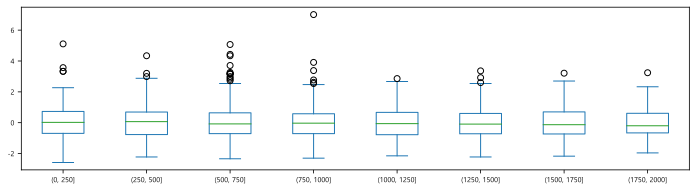

In [115]:
fig, ax = plt.subplots(figsize=(12, 3))
(short
 .assign(SCORE=score)
 .reset_index(drop=True)
 # DatetimeIndex일 때는 pivot이 안 먹는데 왜지..?
 .pivot(columns='BIN', values='SCORE')
 .plot.box(fontsize=7, ax=ax)
)

In [117]:
mask = (short
 .assign(SCORE=score)
 .reset_index(drop=True)
 .pipe(lambda df: df.SCORE.abs() > 5)
)
mask

0       False
1       False
2       False
3       False
4       False
        ...  
4887    False
4888    False
4889    False
4890    False
4891    False
Name: SCORE, Length: 4892, dtype: bool

In [123]:
outliers = (short
 .assign(SCORE=score)
 .reset_index(drop=True)
 .loc[:, ['DIST', 'AIR_TIME']]
 .loc[mask, :]
 .assign(PLOT_NUM=lambda df: range(1, len(df) + 1))
)
outliers

,DIST,AIR_TIME,PLOT_NUM
747,152,78.0,1
1204,802,210.0,2
4553,731,144.0,3


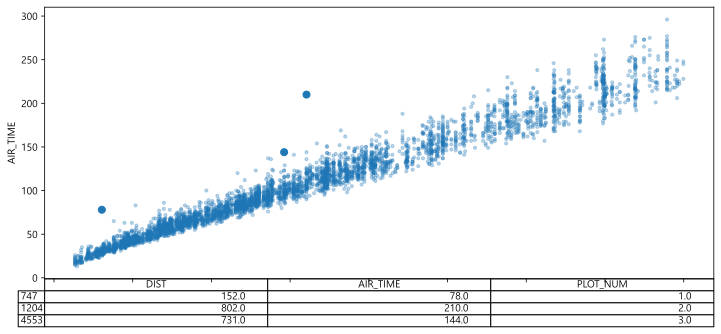

In [139]:
fig, ax = plt.subplots(figsize=(12, 5))
(short
 .assign(SCORE=score)
 .reset_index(drop=True)
 .plot.scatter(x='DIST', y='AIR_TIME', ax=ax, alpha=0.3, s=10, table=outliers)
)
(outliers
 .plot.scatter(x='DIST', y='AIR_TIME', ax=ax, s=50)
)
ax.set_xticklabels('')
ax.set_xlabel(None)
plt.show()

In [141]:
meetup = pd.read_csv(p1 / 'meetup_groups.csv', parse_dates=['join_date'], index_col='join_date')
meetup.head()

,group,city,state,country
join_date,,,,
2016-11-18 02:41:29,houston machine learning,Houston,TX,us
2017-05-09 14:16:37,houston machine learning,Houston,TX,us
2016-12-30 02:34:16,houston machine learning,Houston,TX,us
2016-07-18 00:48:17,houston machine learning,Houston,TX,us
2017-05-25 12:58:16,houston machine learning,Houston,TX,us


In [147]:
(meetup
 .groupby([pd.Grouper(freq='W'), 'group'])
 .size()
 .unstack('group', fill_value=0)
 .cumsum(axis=0)
 .pipe(lambda df: df.div(df.sum(axis=1), axis=0))
)

group,houston data science,houston data visualization,houston energy data science,houston machine learning,houstonr
join_date,,,,,
2010-11-07,0.000000,0.000000,0.000000,0.000000,1.000000
2010-11-14,0.000000,0.000000,0.000000,0.000000,1.000000
2010-11-21,0.000000,0.000000,0.000000,0.000000,1.000000
2010-12-05,0.000000,0.000000,0.000000,0.000000,1.000000
2011-01-16,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...
2017-09-17,0.282058,0.228862,0.252713,0.094868,0.141498
2017-09-24,0.282409,0.227629,0.252892,0.095732,0.141338
2017-10-01,0.283074,0.226829,0.251914,0.097703,0.140481


<AxesSubplot:xlabel='join_date'>

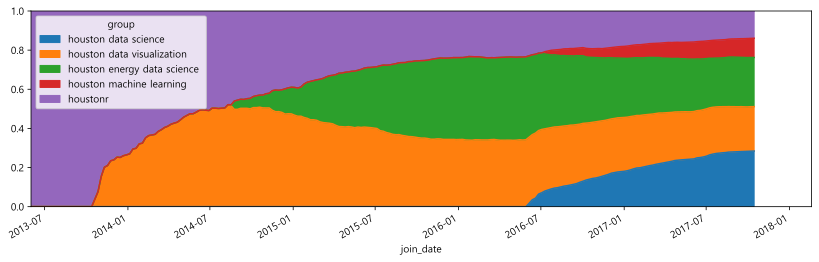

In [149]:
fig, ax = plt.subplots(figsize=(14, 4))
(meetup
 .groupby([pd.Grouper(freq='W'), 'group'])
 .size()
 .unstack('group', fill_value=0)
 .cumsum(axis=0)
 .pipe(lambda df: df.div(df.sum(axis=1), axis=0))
 .plot.area(ax=ax, xlim=('2013-06', None), ylim=(0, 1))
)